In [1]:
import pandas as pd 
import string
import re 
import nltk
import emoji
import numpy
import time
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix,f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import np
from collections import Counter
from textblob import TextBlob 
from langdetect import detect

In [2]:
def make_confusion_matrix(cf, group_names=None, categories='auto', count=True, percent=True, cbar=True, xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('conf.pdf')  

    if title:
        plt.title(title)
        

In [3]:
# Read dataset
test_tweets = pd.read_csv('mediaeval-2015-testset.txt', sep='\\t', engine='python', encoding='utf-8')
train_tweets = pd.read_csv('mediaeval-2015-trainingset.txt', sep='\\t', engine='python', encoding='utf-8')

def removeColumns(tweets):
    tweets.drop(["timestamp"],axis=1,inplace=True)
    tweets.drop(["username"],axis=1,inplace=True)
    tweets.drop(["tweetId"],axis=1,inplace=True)
    tweets.drop(["userId"],axis=1,inplace=True)
    tweets.drop(["imageId(s)"],axis=1,inplace=True)

# Remove Columns
removeColumns(train_tweets)
removeColumns(test_tweets)

def converHumourLabel(tweets):
    tweets.loc[tweets['label'] == 'humor', 'label'] = 'fake'
    
# Change 'humor' to 'fake'
converHumourLabel(train_tweets)
converHumourLabel(test_tweets)


def englishTweets(tweets):
    # Generate lang
    ls = [] 
    for value in tweets["preprocessed"]: 
        if not (value == "en"):
            ls.append(detect(str(tweets)))
        else:
            ls.append("ND")
    tweets["lang"] = ls 
    return tweets

def clean(text):
    # Remove URLs
    tweet =  re.sub(r'http\S+', '', text)
    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove all the special characters
    tweet = re.sub(r'\W', ' ', tweet)
    # Convert to lower case
    tweet = tweet.lower()
    return tweet


# Remove stop words
def remove_stopwords(text):
    event_words = ['hurricane', 'sochi',
                   'soldier', 'hurricanesandy', 
                   'liberty', 'bringbackourgirls', 'jersey', 'manhattan','flood',
                   'nj', 'new', 'nyc', 'ny', 'york', 'statue',
                   'statueofliberty', 'shark', 'newyork', 
                   'tomb',  'mh370', 'sandy', 'huracán', 'boston',  
                   'columbianchemicals',
                    'flooding', 'cuba']
    
    twitter = ['via', 'photo', 'rt']
    en_stop_words = nltk.corpus.stopwords.words('english')
    sp_stop_words = nltk.corpus.stopwords.words('spanish')
    stopword = en_stop_words + sp_stop_words + twitter + event_words
    text= ' '.join([word for word in text.split() if word not in stopword])
    return text

def stemming(text):
    tokens = word_tokenize(text)
    stemmer = PorterStemmer()
    stems = [stemmer.stem(w) for w in tokens]
    return ' '.join(stems)

# Clean text
train_tweets['preprocessed'] = train_tweets['tweetText'].apply(clean)
test_tweets['preprocessed'] = test_tweets['tweetText'].apply(clean)

# train_tweets = englishTweets()

    
# Remove stopwords
train_tweets['preprocessed'] = train_tweets['preprocessed'].apply(remove_stopwords)
test_tweets['preprocessed'] = test_tweets['preprocessed'].apply(remove_stopwords)

# Perform stemming - ineffective
# train_tweets['preprocessed'] = train_tweets['preprocessed'].apply(stemming)
# test_tweets['preprocessed'] = test_tweets['preprocessed'].apply(stemming)



test_tweets.to_csv('test_tweets.csv')
train_tweets.to_csv('train_tweets.csv')

train_tweets.head()

,tweetText,label,preprocessed
0,¿Se acuerdan de la película: “El día después d...,fake,acuerdan película día después mañana recuerda ...
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,fake,miren tremenda imagen parece día independencia...
2,"Buena la foto del Huracán Sandy, me recuerda a...",fake,buena foto recuerda película día independencia...
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,fake,scary shit
4,My fave place in the world #nyc #hurricane #sa...,fake,fave place world


In [4]:
# Define x and y train and test set
x_train = train_tweets['preprocessed']
x_test = test_tweets['preprocessed']
y_train = train_tweets['label']
y_test = test_tweets['label']

# classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1,1))),
    ('clf', svm.SVC(kernel='linear',C=1.9, gamma='auto')),
])

parameters = {
    'tfidf__max_features': (3600,10000)
}

f1_scorer = make_scorer(f1_score, average='micro', pos_label="fake")

# find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=10 , verbose=1,scoring=f1_scorer)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)
t0 = time.time()
grid_search.fit(x_train, y_train)
print("done in %0.3fs" % (time.time() - t0))
print()
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    


Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_features': (3600, 10000)}
Fitting 10 folds for each of 2 candidates, totalling 20 fits
done in 26.190s

Best score: 0.846
Best parameters set:
	tfidf__max_features: 3600


In [5]:
predictions = grid_search.predict(x_test)
print("micro F1 score: " + str(f1_score(y_test, predictions, average='micro')))

micro F1 score: 0.8804549061094947


micro F1-score: 0.8804549061094947
macro F1-score: 0.8589963182538833


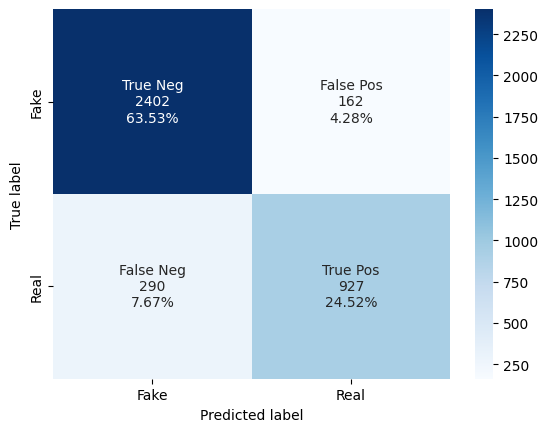

In [6]:
# Define x and y train and test set
x_train = train_tweets['preprocessed']
x_test = test_tweets['preprocessed']
y_train = train_tweets['label']
y_test = test_tweets['label']

# TF-IDF vectorizer TfidfVectorizer()
# Tfidf_vect = TfidfVectorizer(max_features=3600, min_df=2, max_df=0.5, ngram_range=(1,1))
# Tfidf_vect = TfidfVectorizer()

# unigrams performs very well
# Tfidf_vect = CountVectorizer(max_features=3600, min_df=2, ngram_range=(1,1)) 

Tfidf_vect = TfidfVectorizer(max_features=3600, min_df=2, max_df=0.5, ngram_range=(1,1))


Tfidf_vect.fit(train_tweets['preprocessed'])
train_x_tfidf = Tfidf_vect.transform(x_train)
test_x_tfidf = Tfidf_vect.transform(x_test)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake', 'Real']

# Classifier - Support Vector Machine
SVM = svm.SVC(C=1.9, kernel='linear')
SVM.fit(train_x_tfidf, y_train)
svm_predictions = SVM.predict(test_x_tfidf)
svm_cf_matrix = confusion_matrix(y_test, svm_predictions)

make_confusion_matrix(svm_cf_matrix, group_names=labels, categories=categories, cmap='Blues')
print("micro F1-score: " + str(f1_score(y_test, svm_predictions, average='micro')))
print("macro F1-score: " + str(f1_score(y_test, svm_predictions, average='macro')))

